# Libs & Util

In [1]:
# Extracting Features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import noisereduce as nr
import IPython
from tqdm.notebook import tqdm
import json

# Training neural networks
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split

# Live detection
import pyaudio
from IPython.display import clear_output
import wave

# ms per chunk
STEP = 50
PATH = "whistle_dataset/"

2022-06-21 11:53:24.647622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 11:53:24.647653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Extracting features

## Chunk processor

>The chunk processor will get a sample with a feature type, and will utilize these to process said chunk into features. The chunk processor is used in both featurizers.

In [2]:
# def chunk_processor(sample, sample_rate, feature_type, target, false_window = 1, true_window= 1/50):
#def chunk_processor(sample, sample_rate, feature_type, target, false_window = 10, true_window= 1/5):
def chunk_processor(sample, sample_rate, feature_type, target, false_window = 25, true_window= 1/2):
    
    # get correct window variable
    if target:
        window = true_window
    else:
        window = false_window
        
    # calculate chunk size
    chunk = int((sample_rate / 1000) * STEP)
    
    # iterate over sample and fetch features
    for i in tqdm(range(0, len(sample) - chunk, int(chunk * window)), leave=False):
        if feature_type == "fft":
            chunk_features = np.mean(np.abs(librosa.stft(sample[i:i+chunk], n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            chunk_features = np.mean(librosa.feature.mfcc(y=sample[i:i+chunk], sr=sample_rate, n_mfcc=40).T, axis=0)
        
        try:
            features = np.append(features, np.array([chunk_features]), axis=0)
        except:
            features = np.array([chunk_features])
            
    return features, np.full(len(features), int(target))

## Featurizer V1

> Featurizer 1 only uses the whistle, and the segments before and after (same length). This is how a 2:1 label ratio is managed.

In [3]:
def build_feature_dataframe_v1(feature_type, denoise=False):
    """Convert all whistles and small fragments before and after said whistles into features"""
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)

        # for all positive intervals get part before and after aswell and featurize
        for times in tqdm(labels[file_name], leave=False):
            delta_time = times["end"] - times["start"]
            
            label = False
            for i in range(times["start"]-delta_time, times["end"]+delta_time, delta_time):
                if i >= 0 and i + delta_time <= len(sample):
                    features, targets = chunk_processor(sample[i:i+delta_time], sample_rate, feature_type, label, 
                                                        false_window = 1/5, true_window= 1/5)
                    label = not(label)
                    try:
                        out = np.append(out, features, axis=0)
                        target = np.append(target, targets)
                    except:
                        out = features
                        target = targets
                else:
                    print(file_name, i, 'no fit ;(')

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv")
    return df

## Featurizer V2

> Featurizer 2 utilises two different overlap values. True labels have 1/2 overlap, meaning that sequential samples have 50% overlap. False labels have a overlap value of 25, meaning that after each sample taken 24 are skipped. This insures that a 2:1 label ratio is kept while still taking a more fair representation of the dataset.

In [4]:
def build_feature_dataframe_v2(feature_type, denoise=False):
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)
        
        # create time intervals
        times_list = [0]
        for times in labels[file_name]:
            times_list += [times["start"], times["end"]]
        if times_list[-1] < len(sample):
            times_list.append(len(sample))
        
        label = False
        for i in tqdm(range(len(times_list)-1), leave=False):
            features, targets = chunk_processor(sample[times_list[i]:times_list[i+1]], sample_rate, feature_type, label)
            label = not(label)
            try:
                out = np.append(out, features, axis=0)
                target = np.append(target, targets)
            except:
                out = features
                target = targets

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv")
    return df

In [5]:
def build_features(version, feature_type, denoise):
    if version == 1:
        return build_feature_dataframe_v1(feature_type, denoise)
    elif version == 2:
        return build_feature_dataframe_v2(feature_type, denoise)
    else:
        print("invalid version")

In [6]:
mass_data = build_features(1, "mfcc", False)
print("True label ratio:", round((len(mass_data[mass_data["target"] == 1]) / len(mass_data["target"])) * 100, 1),"%")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

WhistleTest_tuhhnao16.wav 28116000 no fit ;(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

True label ratio: 33.5 %


## Dataset debugging

> The following code allows for any whistle sample to be extracted in order to check if they are labeled correctly.

In [7]:
# Choose recording
i = -1
fname = os.listdir(PATH)[i]
print(fname)

with open(PATH + "whistledb.json") as json_file:
    labels = json.load(json_file)["audioFiles"]
    labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
print(labels[fname], len(labels[fname]))

sample_tts, sr = librosa.load(PATH + fname, sr=None)

TestBHuman_03_05_2017_1413.wav
[{'start': 445000, 'end': 480000, 'coreStart': 447000, 'coreEnd': 455000}, {'start': 3065000, 'end': 3110000, 'coreStart': 0, 'coreEnd': 0}] 2


In [8]:
# Choose whistle number
i = -1
print(os.listdir(PATH))
print(labels[fname][i]["start"],labels[fname][i]["end"])

IPython.display.Audio(sample_tts[labels[fname][i]["start"]:labels[fname][i]["end"]], rate=sr)

['Lab_Fox40_vs_printed.wav', 'WhistleTest_tuhhnao12.wav', 'HTWK_HULKs_1930_2016_04_29.wav', 'LUnitedvsUPenn20170728Half2.wav', 'HTWK_Dutch_05_04_2017.wav', 'LUnitedvsUPenn20170728.wav', 'WhistleTest_tuhhnao16.wav', 'SRC_Dutch_05-04-2017.wav', 'whistledb.json', 'HTWK_Dutch_05_04_2017-2.wav', 'TestBHuman_03_05_2017_1413.wav']
3065000 3110000


# Training neural networks

## Support functions

In [9]:
# Randomise and split dataframe into X and Y
def feature_target_split(df, shuffle=True):
    if shuffle:
        df = df.sample(frac = 1)
    
    dataset = df.values
    X = dataset[:,1:].astype(float)
    
    Y = dataset[:,0]
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    
    return X, Y

## Neural networks

In [10]:
def two_layer_integrated(X):
    inputs = Input(shape= (X.shape[1],))
    layer = Dense(128, activation="relu")(inputs)
    outputs = Dense(1, activation="sigmoid")(layer)
    model = Model(inputs, outputs)
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["acc"])
    mc = ModelCheckpoint("best_model_simple.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    return model, mc

Dataframe succesfully loaded from csv!
Epoch 1/200


2022-06-21 11:54:16.144996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-21 11:54:16.145011: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 11:54:16.145033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dan-XPS-15): /proc/driver/nvidia/version does not exist
2022-06-21 11:54:16.145353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


361/376 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8284
Epoch 1: val_loss improved from inf to 0.22039, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.3873 - acc: 0.8319 - val_loss: 0.2204 - val_acc: 0.9284
Epoch 2/200
351/376 [===========================>..] - ETA: 0s - loss: 0.1922 - acc: 0.9293
Epoch 2: val_loss improved from 0.22039 to 0.14920, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.1890 - acc: 0.9310 - val_loss: 0.1492 - val_acc: 0.9444
Epoch 3/200
332/376 [=========================>....] - ETA: 0s - loss: 0.1439 - acc: 0.9469
Epoch 3: val_loss improved from 0.14920 to 0.12161, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.1431 - acc: 0.9472 - val_loss: 0.1216 - val_acc: 0.9530
Epoch 4/200
341/376 [==========================>...] - ETA: 0s - loss: 0.1230 - acc: 0.9542
Epoch 4: val

Epoch 29/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0415 - acc: 0.9840
Epoch 29: val_loss did not improve from 0.03951
376/376 [==============================] - 1s 2ms/step - loss: 0.0413 - acc: 0.9841 - val_loss: 0.0419 - val_acc: 0.9830
Epoch 30/200
371/376 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9843
Epoch 30: val_loss did not improve from 0.03951
376/376 [==============================] - 0s 1ms/step - loss: 0.0399 - acc: 0.9843 - val_loss: 0.0429 - val_acc: 0.9837
Epoch 31/200
376/376 [==============================] - ETA: 0s - loss: 0.0424 - acc: 0.9840
Epoch 31: val_loss improved from 0.03951 to 0.03928, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0424 - acc: 0.9840 - val_loss: 0.0393 - val_acc: 0.9830
Epoch 32/200
354/376 [===========================>..] - ETA: 0s - loss: 0.0399 - acc: 0.9842
Epoch 32: val_loss improved from 0.03928 to 0.03845, saving model to best_mod

Epoch 59/200
361/376 [===========================>..] - ETA: 0s - loss: 0.0285 - acc: 0.9886
Epoch 59: val_loss improved from 0.03294 to 0.03117, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0287 - acc: 0.9883 - val_loss: 0.0312 - val_acc: 0.9877
Epoch 60/200
356/376 [===========================>..] - ETA: 0s - loss: 0.0283 - acc: 0.9900
Epoch 60: val_loss did not improve from 0.03117
376/376 [==============================] - 0s 1ms/step - loss: 0.0283 - acc: 0.9899 - val_loss: 0.0379 - val_acc: 0.9833
Epoch 61/200
369/376 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9899
Epoch 61: val_loss improved from 0.03117 to 0.03000, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0284 - acc: 0.9901 - val_loss: 0.0300 - val_acc: 0.9877
Epoch 62/200
330/376 [=========================>....] - ETA: 0s - loss: 0.0286 - acc: 0.9898
Epoch 62: val_loss did not improv

Epoch 89/200
374/376 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9911
Epoch 89: val_loss did not improve from 0.02647
376/376 [==============================] - 1s 1ms/step - loss: 0.0225 - acc: 0.9912 - val_loss: 0.0313 - val_acc: 0.9887
Epoch 90/200
354/376 [===========================>..] - ETA: 0s - loss: 0.0229 - acc: 0.9916
Epoch 90: val_loss did not improve from 0.02647
376/376 [==============================] - 1s 2ms/step - loss: 0.0225 - acc: 0.9917 - val_loss: 0.0381 - val_acc: 0.9850
Epoch 91/200
339/376 [==========================>...] - ETA: 0s - loss: 0.0242 - acc: 0.9910
Epoch 91: val_loss improved from 0.02647 to 0.02474, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0236 - acc: 0.9914 - val_loss: 0.0247 - val_acc: 0.9903
Epoch 92/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0240 - acc: 0.9903
Epoch 92: val_loss did not improve from 0.02474
376/376 [====================

364/376 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9932
Epoch 119: val_loss did not improve from 0.02279
376/376 [==============================] - 0s 1ms/step - loss: 0.0185 - acc: 0.9933 - val_loss: 0.0233 - val_acc: 0.9910
Epoch 120/200
330/376 [=========================>....] - ETA: 0s - loss: 0.0172 - acc: 0.9937
Epoch 120: val_loss improved from 0.02279 to 0.02201, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0188 - acc: 0.9928 - val_loss: 0.0220 - val_acc: 0.9920
Epoch 121/200
366/376 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9941
Epoch 121: val_loss did not improve from 0.02201
376/376 [==============================] - 0s 1ms/step - loss: 0.0175 - acc: 0.9941 - val_loss: 0.0223 - val_acc: 0.9910
Epoch 122/200
368/376 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9934
Epoch 122: val_loss did not improve from 0.02201
376/376 [==========================

Epoch 150/200
356/376 [===========================>..] - ETA: 0s - loss: 0.0175 - acc: 0.9939
Epoch 150: val_loss did not improve from 0.01945
376/376 [==============================] - 1s 1ms/step - loss: 0.0173 - acc: 0.9940 - val_loss: 0.0203 - val_acc: 0.9930
Epoch 151/200
359/376 [===========================>..] - ETA: 0s - loss: 0.0139 - acc: 0.9949
Epoch 151: val_loss did not improve from 0.01945
376/376 [==============================] - 0s 1ms/step - loss: 0.0144 - acc: 0.9948 - val_loss: 0.0206 - val_acc: 0.9917
Epoch 152/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0150 - acc: 0.9942
Epoch 152: val_loss did not improve from 0.01945
376/376 [==============================] - 0s 1ms/step - loss: 0.0147 - acc: 0.9943 - val_loss: 0.0201 - val_acc: 0.9927
Epoch 153/200
339/376 [==========================>...] - ETA: 0s - loss: 0.0146 - acc: 0.9944
Epoch 153: val_loss did not improve from 0.01945
376/376 [==============================] - 0s 1ms/step - loss: 0.

376/376 [==============================] - 1s 1ms/step - loss: 0.0117 - acc: 0.9954 - val_loss: 0.0214 - val_acc: 0.9917
Epoch 181/200
340/376 [==========================>...] - ETA: 0s - loss: 0.0126 - acc: 0.9954
Epoch 181: val_loss improved from 0.01731 to 0.01715, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0126 - acc: 0.9955 - val_loss: 0.0172 - val_acc: 0.9947
Epoch 182/200
375/376 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9952
Epoch 182: val_loss improved from 0.01715 to 0.01687, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0125 - acc: 0.9952 - val_loss: 0.0169 - val_acc: 0.9930
Epoch 183/200
361/376 [===========================>..] - ETA: 0s - loss: 0.0115 - acc: 0.9960
Epoch 183: val_loss did not improve from 0.01687
376/376 [==============================] - 1s 1ms/step - loss: 0.0117 - acc: 0.9960 - val_loss: 0.0190 - val_acc: 0.9920

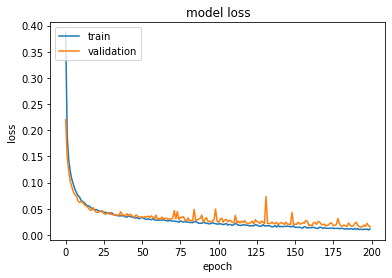

In [11]:
def train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=False):
    
    # model training
    model, model_checkpoint = two_layer_integrated(X_train)
    history = model.fit(X_train, Y_train ,epochs=200, callbacks=[model_checkpoint], batch_size=32, 
                        validation_data=(X_test, Y_test))

    # load the best model weights
    model.load_weights('best_model_simple.hdf5')
    
    # save model
    model.save("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")

    # summarize history for loss
    if plot:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    return model
        
def train_model(version, feature_type, denoise):
    # load data
    mass_data = build_features(version, feature_type, denoise)
    
    # train test split
    X, Y = feature_target_split(mass_data)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, 
                                                        random_state=12, shuffle=True)
    
    return X_test, Y_test, train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=True)
        

X_test, Y_test, model = train_model(1, "mfcc", False)

94/94 [==============================] - 0s 767us/step


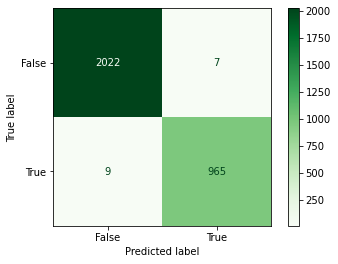

In [12]:
cm = confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
disp.plot(cmap="Greens")

## K-fold validation

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

WhistleTest_tuhhnao16.wav 28116000 no fit ;(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/200
361/376 [===========================>..] - ETA: 0s - loss: 0.3104 - acc: 0.8944
Epoch 1: val_loss improved from inf to 0.20099, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.3070 - acc: 0.8950 - val_loss: 0.2010 - val_acc: 0.9184
Epoch 2/200
368/376 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9412
Epoch 2: val_loss improved from 0.20099 to 0.15080, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.1626 - acc: 0.9407 - val_loss: 0.1508 - val_acc: 0.9447
Epoch 3/200
349/376 [==========================>...] - ETA: 0s - loss: 0.1335 - acc: 0.9529
Epoch 3: val_loss improved from 0.15080 to 0.13103, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.1356 - acc: 0.9516 - val_loss: 0.1310 - val_acc: 0.9514
Epoch 4/200
371/376 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9561


Epoch 29/200
347/376 [==========================>...] - ETA: 0s - loss: 0.0448 - acc: 0.9835
Epoch 29: val_loss improved from 0.05369 to 0.05273, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0460 - acc: 0.9830 - val_loss: 0.0527 - val_acc: 0.9814
Epoch 30/200
375/376 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9843
Epoch 30: val_loss improved from 0.05273 to 0.05225, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0445 - acc: 0.9843 - val_loss: 0.0522 - val_acc: 0.9810
Epoch 31/200
376/376 [==============================] - ETA: 0s - loss: 0.0447 - acc: 0.9838
Epoch 31: val_loss improved from 0.05225 to 0.05068, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0447 - acc: 0.9838 - val_loss: 0.0507 - val_acc: 0.9814
Epoch 32/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0442 - a

376/376 [==============================] - 1s 1ms/step - loss: 0.0305 - acc: 0.9883 - val_loss: 0.0409 - val_acc: 0.9827
Epoch 58/200
359/376 [===========================>..] - ETA: 0s - loss: 0.0282 - acc: 0.9889
Epoch 58: val_loss did not improve from 0.04091
376/376 [==============================] - 1s 1ms/step - loss: 0.0294 - acc: 0.9883 - val_loss: 0.0530 - val_acc: 0.9814
Epoch 59/200
373/376 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9895
Epoch 59: val_loss improved from 0.04091 to 0.03950, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0291 - acc: 0.9896 - val_loss: 0.0395 - val_acc: 0.9840
Epoch 60/200
370/376 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9883
Epoch 60: val_loss improved from 0.03950 to 0.03926, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0312 - acc: 0.9884 - val_loss: 0.0393 - val_acc: 0.9853
Epoch

Epoch 87/200
357/376 [===========================>..] - ETA: 0s - loss: 0.0212 - acc: 0.9926
Epoch 87: val_loss improved from 0.03246 to 0.03205, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0213 - acc: 0.9927 - val_loss: 0.0320 - val_acc: 0.9853
Epoch 88/200
375/376 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9923
Epoch 88: val_loss improved from 0.03205 to 0.03199, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0214 - acc: 0.9923 - val_loss: 0.0320 - val_acc: 0.9860
Epoch 89/200
333/376 [=========================>....] - ETA: 0s - loss: 0.0209 - acc: 0.9918
Epoch 89: val_loss improved from 0.03199 to 0.03143, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0207 - acc: 0.9918 - val_loss: 0.0314 - val_acc: 0.9877
Epoch 90/200
336/376 [=========================>....] - ETA: 0s - loss: 0.0206 - a

Epoch 117/200
375/376 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9950
Epoch 117: val_loss did not improve from 0.02764
376/376 [==============================] - 1s 1ms/step - loss: 0.0156 - acc: 0.9950 - val_loss: 0.0291 - val_acc: 0.9860
Epoch 118/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0142 - acc: 0.9957
Epoch 118: val_loss did not improve from 0.02764
376/376 [==============================] - 1s 1ms/step - loss: 0.0144 - acc: 0.9957 - val_loss: 0.0374 - val_acc: 0.9853
Epoch 119/200
340/376 [==========================>...] - ETA: 0s - loss: 0.0154 - acc: 0.9944
Epoch 119: val_loss did not improve from 0.02764
376/376 [==============================] - 0s 1ms/step - loss: 0.0153 - acc: 0.9944 - val_loss: 0.0297 - val_acc: 0.9880
Epoch 120/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0147 - acc: 0.9949
Epoch 120: val_loss did not improve from 0.02764
376/376 [==============================] - 1s 1ms/step - loss: 0.

332/376 [=========================>....] - ETA: 0s - loss: 0.0121 - acc: 0.9957
Epoch 147: val_loss did not improve from 0.02510
376/376 [==============================] - 0s 1ms/step - loss: 0.0123 - acc: 0.9958 - val_loss: 0.0266 - val_acc: 0.9893
Epoch 148/200
361/376 [===========================>..] - ETA: 0s - loss: 0.0110 - acc: 0.9964
Epoch 148: val_loss improved from 0.02510 to 0.02457, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0109 - acc: 0.9964 - val_loss: 0.0246 - val_acc: 0.9897
Epoch 149/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0110 - acc: 0.9961
Epoch 149: val_loss improved from 0.02457 to 0.02424, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0111 - acc: 0.9960 - val_loss: 0.0242 - val_acc: 0.9900
Epoch 150/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9967
Epoch 150: val_loss did not improve from

376/376 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 0.9976 - val_loss: 0.0215 - val_acc: 0.9907
Epoch 177/200
372/376 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9980
Epoch 177: val_loss improved from 0.02153 to 0.02119, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.0212 - val_acc: 0.9910
Epoch 178/200
375/376 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9977
Epoch 178: val_loss did not improve from 0.02119
376/376 [==============================] - 0s 1ms/step - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0218 - val_acc: 0.9910
Epoch 179/200
354/376 [===========================>..] - ETA: 0s - loss: 0.0080 - acc: 0.9977
Epoch 179: val_loss did not improve from 0.02119
376/376 [==============================] - 1s 1ms/step - loss: 0.0079 - acc: 0.9977 - val_loss: 0.0240 - val_acc: 0.9903
Epoch 180/200
375/376 [====================

Epoch 6/200
344/376 [==========================>...] - ETA: 0s - loss: 0.1033 - acc: 0.9628
Epoch 6: val_loss improved from 0.12771 to 0.11763, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.1024 - acc: 0.9634 - val_loss: 0.1176 - val_acc: 0.9590
Epoch 7/200
344/376 [==========================>...] - ETA: 0s - loss: 0.0968 - acc: 0.9657
Epoch 7: val_loss improved from 0.11763 to 0.11237, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0963 - acc: 0.9655 - val_loss: 0.1124 - val_acc: 0.9600
Epoch 8/200
352/376 [===========================>..] - ETA: 0s - loss: 0.0936 - acc: 0.9657
Epoch 8: val_loss improved from 0.11237 to 0.10813, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0936 - acc: 0.9656 - val_loss: 0.1081 - val_acc: 0.9627
Epoch 9/200
350/376 [==========================>...] - ETA: 0s - loss: 0.0909 - acc: 0.9

376/376 [==============================] - 0s 1ms/step - loss: 0.0443 - acc: 0.9840 - val_loss: 0.0512 - val_acc: 0.9817
Epoch 34/200
350/376 [==========================>...] - ETA: 0s - loss: 0.0429 - acc: 0.9841
Epoch 34: val_loss did not improve from 0.05117
376/376 [==============================] - 0s 1ms/step - loss: 0.0425 - acc: 0.9843 - val_loss: 0.0528 - val_acc: 0.9797
Epoch 35/200
348/376 [==========================>...] - ETA: 0s - loss: 0.0434 - acc: 0.9832
Epoch 35: val_loss improved from 0.05117 to 0.04909, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0428 - acc: 0.9836 - val_loss: 0.0491 - val_acc: 0.9824
Epoch 36/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0400 - acc: 0.9848
Epoch 36: val_loss improved from 0.04909 to 0.04879, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0407 - acc: 0.9845 - val_loss: 0.0488 - val_acc: 0.9820
Epoch

376/376 [==============================] - 1s 1ms/step - loss: 0.0248 - acc: 0.9903 - val_loss: 0.0344 - val_acc: 0.9880
Epoch 63/200
358/376 [===========================>..] - ETA: 0s - loss: 0.0254 - acc: 0.9898
Epoch 63: val_loss did not improve from 0.03236
376/376 [==============================] - 1s 2ms/step - loss: 0.0252 - acc: 0.9901 - val_loss: 0.0358 - val_acc: 0.9847
Epoch 64/200
355/376 [===========================>..] - ETA: 0s - loss: 0.0237 - acc: 0.9907
Epoch 64: val_loss did not improve from 0.03236
376/376 [==============================] - 1s 1ms/step - loss: 0.0240 - acc: 0.9905 - val_loss: 0.0331 - val_acc: 0.9867
Epoch 65/200
373/376 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9908
Epoch 65: val_loss improved from 0.03236 to 0.03149, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0235 - acc: 0.9908 - val_loss: 0.0315 - val_acc: 0.9880
Epoch 66/200
340/376 [==========================>

Epoch 92/200
342/376 [==========================>...] - ETA: 0s - loss: 0.0152 - acc: 0.9952
Epoch 92: val_loss did not improve from 0.02414
376/376 [==============================] - 1s 1ms/step - loss: 0.0153 - acc: 0.9952 - val_loss: 0.0246 - val_acc: 0.9920
Epoch 93/200
365/376 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9953
Epoch 93: val_loss did not improve from 0.02414
376/376 [==============================] - 1s 2ms/step - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0245 - val_acc: 0.9907
Epoch 94/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0144 - acc: 0.9947
Epoch 94: val_loss improved from 0.02414 to 0.02294, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0143 - acc: 0.9948 - val_loss: 0.0229 - val_acc: 0.9913
Epoch 95/200
371/376 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9951
Epoch 95: val_loss did not improve from 0.02294
376/376 [====================

Epoch 122/200
340/376 [==========================>...] - ETA: 0s - loss: 0.0095 - acc: 0.9977
Epoch 122: val_loss improved from 0.01894 to 0.01874, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0095 - acc: 0.9977 - val_loss: 0.0187 - val_acc: 0.9927
Epoch 123/200
350/376 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9977
Epoch 123: val_loss did not improve from 0.01874
376/376 [==============================] - 0s 1ms/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0205 - val_acc: 0.9913
Epoch 124/200
357/376 [===========================>..] - ETA: 0s - loss: 0.0092 - acc: 0.9976
Epoch 124: val_loss did not improve from 0.01874
376/376 [==============================] - 1s 2ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.0197 - val_acc: 0.9913
Epoch 125/200
344/376 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9970
Epoch 125: val_loss did not improve from 0.01874
376/376 [============

Epoch 152/200
352/376 [===========================>..] - ETA: 0s - loss: 0.0065 - acc: 0.9987
Epoch 152: val_loss did not improve from 0.01565
376/376 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 0.9988 - val_loss: 0.0188 - val_acc: 0.9947
Epoch 153/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0066 - acc: 0.9986
Epoch 153: val_loss did not improve from 0.01565
376/376 [==============================] - 1s 2ms/step - loss: 0.0064 - acc: 0.9987 - val_loss: 0.0159 - val_acc: 0.9930
Epoch 154/200
373/376 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9988
Epoch 154: val_loss did not improve from 0.01565
376/376 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 0.9988 - val_loss: 0.0246 - val_acc: 0.9893
Epoch 155/200
370/376 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9990
Epoch 155: val_loss improved from 0.01565 to 0.01556, saving model to best_model_simple.hdf5
376/376 [============

376/376 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0226 - val_acc: 0.9923
Epoch 183/200
370/376 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9996
Epoch 183: val_loss did not improve from 0.01498
376/376 [==============================] - 0s 1ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 0.0191 - val_acc: 0.9930
Epoch 184/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0036 - acc: 0.9993
Epoch 184: val_loss did not improve from 0.01498
376/376 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 185/200
370/376 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9997
Epoch 185: val_loss did not improve from 0.01498
376/376 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.9998 - val_loss: 0.0230 - val_acc: 0.9927
Epoch 186/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0033 - acc: 

Epoch 12/200
357/376 [===========================>..] - ETA: 0s - loss: 0.0757 - acc: 0.9727
Epoch 12: val_loss improved from 0.08267 to 0.08024, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0763 - acc: 0.9727 - val_loss: 0.0802 - val_acc: 0.9710
Epoch 13/200
339/376 [==========================>...] - ETA: 0s - loss: 0.0745 - acc: 0.9735
Epoch 13: val_loss improved from 0.08024 to 0.07636, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0741 - acc: 0.9736 - val_loss: 0.0764 - val_acc: 0.9730
Epoch 14/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0698 - acc: 0.9739
Epoch 14: val_loss did not improve from 0.07636
376/376 [==============================] - 1s 1ms/step - loss: 0.0705 - acc: 0.9733 - val_loss: 0.0808 - val_acc: 0.9737
Epoch 15/200
364/376 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9748
Epoch 15: val_loss improved from 

Epoch 40/200
355/376 [===========================>..] - ETA: 0s - loss: 0.0348 - acc: 0.9874
Epoch 40: val_loss did not improve from 0.04155
376/376 [==============================] - 1s 1ms/step - loss: 0.0348 - acc: 0.9876 - val_loss: 0.0433 - val_acc: 0.9837
Epoch 41/200
342/376 [==========================>...] - ETA: 0s - loss: 0.0343 - acc: 0.9876
Epoch 41: val_loss improved from 0.04155 to 0.04072, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0343 - acc: 0.9873 - val_loss: 0.0407 - val_acc: 0.9827
Epoch 42/200
341/376 [==========================>...] - ETA: 0s - loss: 0.0353 - acc: 0.9869
Epoch 42: val_loss did not improve from 0.04072
376/376 [==============================] - 1s 2ms/step - loss: 0.0349 - acc: 0.9873 - val_loss: 0.0408 - val_acc: 0.9850
Epoch 43/200
363/376 [===========================>..] - ETA: 0s - loss: 0.0329 - acc: 0.9877
Epoch 43: val_loss improved from 0.04072 to 0.03992, saving model to best_mod

Epoch 69/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0206 - acc: 0.9934
Epoch 69: val_loss did not improve from 0.02680
376/376 [==============================] - 1s 1ms/step - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0282 - val_acc: 0.9877
Epoch 70/200
367/376 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9939
Epoch 70: val_loss did not improve from 0.02680
376/376 [==============================] - 1s 1ms/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0276 - val_acc: 0.9890
Epoch 71/200
359/376 [===========================>..] - ETA: 0s - loss: 0.0197 - acc: 0.9930
Epoch 71: val_loss did not improve from 0.02680
376/376 [==============================] - 1s 1ms/step - loss: 0.0194 - acc: 0.9932 - val_loss: 0.0305 - val_acc: 0.9893
Epoch 72/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0198 - acc: 0.9925
Epoch 72: val_loss improved from 0.02680 to 0.02622, saving model to best_model_simple.hdf5
376/376 [====================

376/376 [==============================] - 1s 2ms/step - loss: 0.0121 - acc: 0.9965 - val_loss: 0.0207 - val_acc: 0.9903
Epoch 99/200
340/376 [==========================>...] - ETA: 0s - loss: 0.0127 - acc: 0.9963
Epoch 99: val_loss improved from 0.02017 to 0.01971, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0123 - acc: 0.9965 - val_loss: 0.0197 - val_acc: 0.9917
Epoch 100/200
375/376 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9965
Epoch 100: val_loss improved from 0.01971 to 0.01881, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0188 - val_acc: 0.9920
Epoch 101/200
355/376 [===========================>..] - ETA: 0s - loss: 0.0117 - acc: 0.9967
Epoch 101: val_loss improved from 0.01881 to 0.01851, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0117 - acc: 0

Epoch 128/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9980
Epoch 128: val_loss did not improve from 0.01464
376/376 [==============================] - 1s 1ms/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.0152 - val_acc: 0.9950
Epoch 129/200
355/376 [===========================>..] - ETA: 0s - loss: 0.0085 - acc: 0.9981
Epoch 129: val_loss did not improve from 0.01464
376/376 [==============================] - 0s 1ms/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.0148 - val_acc: 0.9947
Epoch 130/200
375/376 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9982
Epoch 130: val_loss improved from 0.01464 to 0.01344, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0075 - acc: 0.9982 - val_loss: 0.0134 - val_acc: 0.9947
Epoch 131/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0082 - acc: 0.9980
Epoch 131: val_loss did not improve from 0.01344
376/376 [============

Epoch 158/200
369/376 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9986
Epoch 158: val_loss did not improve from 0.01090
376/376 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 0.9987 - val_loss: 0.0126 - val_acc: 0.9950
Epoch 159/200
353/376 [===========================>..] - ETA: 0s - loss: 0.0053 - acc: 0.9995
Epoch 159: val_loss did not improve from 0.01090
376/376 [==============================] - 1s 2ms/step - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0110 - val_acc: 0.9953
Epoch 160/200
357/376 [===========================>..] - ETA: 0s - loss: 0.0050 - acc: 0.9991
Epoch 160: val_loss did not improve from 0.01090
376/376 [==============================] - 1s 2ms/step - loss: 0.0050 - acc: 0.9992 - val_loss: 0.0130 - val_acc: 0.9960
Epoch 161/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0052 - acc: 0.9989
Epoch 161: val_loss did not improve from 0.01090
376/376 [==============================] - 1s 1ms/step - loss: 0.

Epoch 188/200
356/376 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 0.9998
Epoch 188: val_loss did not improve from 0.00847
376/376 [==============================] - 1s 2ms/step - loss: 0.0032 - acc: 0.9998 - val_loss: 0.0090 - val_acc: 0.9963
Epoch 189/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 0.9997
Epoch 189: val_loss did not improve from 0.00847
376/376 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0118 - val_acc: 0.9953
Epoch 190/200
356/376 [===========================>..] - ETA: 0s - loss: 0.0033 - acc: 0.9994
Epoch 190: val_loss did not improve from 0.00847
376/376 [==============================] - 1s 2ms/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0106 - val_acc: 0.9960
Epoch 191/200
376/376 [==============================] - ETA: 0s - loss: 0.0039 - acc: 0.9993
Epoch 191: val_loss did not improve from 0.00847
376/376 [==============================] - 1s 1ms/step - loss: 0.

376/376 [==============================] - 1s 1ms/step - loss: 0.0710 - acc: 0.9734 - val_loss: 0.0577 - val_acc: 0.9767
Epoch 17/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0681 - acc: 0.9752
Epoch 17: val_loss improved from 0.05770 to 0.05452, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0679 - acc: 0.9749 - val_loss: 0.0545 - val_acc: 0.9754
Epoch 18/200
353/376 [===========================>..] - ETA: 0s - loss: 0.0659 - acc: 0.9749
Epoch 18: val_loss improved from 0.05452 to 0.05241, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0652 - acc: 0.9748 - val_loss: 0.0524 - val_acc: 0.9770
Epoch 19/200
366/376 [============================>.] - ETA: 0s - loss: 0.0650 - acc: 0.9754
Epoch 19: val_loss did not improve from 0.05241
376/376 [==============================] - 1s 1ms/step - loss: 0.0643 - acc: 0.9758 - val_loss: 0.0575 - val_acc: 0.9744
Epoch

Epoch 45/200
353/376 [===========================>..] - ETA: 0s - loss: 0.0389 - acc: 0.9847
Epoch 45: val_loss improved from 0.03157 to 0.02986, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0299 - val_acc: 0.9900
Epoch 46/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0368 - acc: 0.9856
Epoch 46: val_loss did not improve from 0.02986
376/376 [==============================] - 1s 2ms/step - loss: 0.0364 - acc: 0.9858 - val_loss: 0.0344 - val_acc: 0.9910
Epoch 47/200
355/376 [===========================>..] - ETA: 0s - loss: 0.0354 - acc: 0.9858
Epoch 47: val_loss did not improve from 0.02986
376/376 [==============================] - 1s 1ms/step - loss: 0.0359 - acc: 0.9857 - val_loss: 0.0310 - val_acc: 0.9873
Epoch 48/200
333/376 [=========================>....] - ETA: 0s - loss: 0.0347 - acc: 0.9868
Epoch 48: val_loss improved from 0.02986 to 0.02902, saving model to best_mod

Epoch 75/200
375/376 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9907
Epoch 75: val_loss did not improve from 0.02275
376/376 [==============================] - 1s 2ms/step - loss: 0.0249 - acc: 0.9907 - val_loss: 0.0247 - val_acc: 0.9923
Epoch 76/200
359/376 [===========================>..] - ETA: 0s - loss: 0.0250 - acc: 0.9906
Epoch 76: val_loss improved from 0.02275 to 0.02249, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0252 - acc: 0.9905 - val_loss: 0.0225 - val_acc: 0.9917
Epoch 77/200
374/376 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9910
Epoch 77: val_loss did not improve from 0.02249
376/376 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.9909 - val_loss: 0.0228 - val_acc: 0.9893
Epoch 78/200
369/376 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9904
Epoch 78: val_loss did not improve from 0.02249
376/376 [====================

365/376 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9934
Epoch 105: val_loss did not improve from 0.01794
376/376 [==============================] - 1s 1ms/step - loss: 0.0175 - acc: 0.9936 - val_loss: 0.0195 - val_acc: 0.9927
Epoch 106/200
353/376 [===========================>..] - ETA: 0s - loss: 0.0181 - acc: 0.9934
Epoch 106: val_loss did not improve from 0.01794
376/376 [==============================] - 1s 1ms/step - loss: 0.0180 - acc: 0.9934 - val_loss: 0.0191 - val_acc: 0.9943
Epoch 107/200
368/376 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9939
Epoch 107: val_loss improved from 0.01794 to 0.01793, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0167 - acc: 0.9938 - val_loss: 0.0179 - val_acc: 0.9930
Epoch 108/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0171 - acc: 0.9939
Epoch 108: val_loss did not improve from 0.01793
376/376 [==========================

Epoch 135/200
347/376 [==========================>...] - ETA: 0s - loss: 0.0144 - acc: 0.9954
Epoch 135: val_loss did not improve from 0.01543
376/376 [==============================] - 1s 1ms/step - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0157 - val_acc: 0.9947
Epoch 136/200
344/376 [==========================>...] - ETA: 0s - loss: 0.0126 - acc: 0.9958
Epoch 136: val_loss did not improve from 0.01543
376/376 [==============================] - 1s 2ms/step - loss: 0.0124 - acc: 0.9962 - val_loss: 0.0162 - val_acc: 0.9943
Epoch 137/200
375/376 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9965
Epoch 137: val_loss improved from 0.01543 to 0.01455, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0145 - val_acc: 0.9950
Epoch 138/200
337/376 [=========================>....] - ETA: 0s - loss: 0.0117 - acc: 0.9970
Epoch 138: val_loss did not improve from 0.01455
376/376 [============

343/376 [==========================>...] - ETA: 0s - loss: 0.0094 - acc: 0.9974
Epoch 165: val_loss did not improve from 0.01334
376/376 [==============================] - 1s 2ms/step - loss: 0.0093 - acc: 0.9974 - val_loss: 0.0161 - val_acc: 0.9943
Epoch 166/200
346/376 [==========================>...] - ETA: 0s - loss: 0.0092 - acc: 0.9972
Epoch 166: val_loss did not improve from 0.01334
376/376 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 0.9973 - val_loss: 0.0231 - val_acc: 0.9883
Epoch 167/200
368/376 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9971
Epoch 167: val_loss did not improve from 0.01334
376/376 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 0.9972 - val_loss: 0.0138 - val_acc: 0.9943
Epoch 168/200
363/376 [===========================>..] - ETA: 0s - loss: 0.0088 - acc: 0.9977
Epoch 168: val_loss improved from 0.01334 to 0.01248, saving model to best_model_simple.hdf5
376/376 [==========================

Epoch 196/200
363/376 [===========================>..] - ETA: 0s - loss: 0.0073 - acc: 0.9983
Epoch 196: val_loss did not improve from 0.01192
376/376 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 0.9983 - val_loss: 0.0139 - val_acc: 0.9953
Epoch 197/200
342/376 [==========================>...] - ETA: 0s - loss: 0.0064 - acc: 0.9984
Epoch 197: val_loss did not improve from 0.01192
376/376 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 0.9983 - val_loss: 0.0145 - val_acc: 0.9953
Epoch 198/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0064 - acc: 0.9989
Epoch 198: val_loss did not improve from 0.01192
376/376 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 0.9989 - val_loss: 0.0181 - val_acc: 0.9957
Epoch 199/200
369/376 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9985
Epoch 199: val_loss did not improve from 0.01192
376/376 [==============================] - 1s 1ms/step - loss: 0.

349/376 [==========================>...] - ETA: 0s - loss: 0.0547 - acc: 0.9782
Epoch 24: val_loss improved from 0.05926 to 0.05535, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 2ms/step - loss: 0.0538 - acc: 0.9786 - val_loss: 0.0553 - val_acc: 0.9800
Epoch 25/200
360/376 [===========================>..] - ETA: 0s - loss: 0.0525 - acc: 0.9798
Epoch 25: val_loss did not improve from 0.05535
376/376 [==============================] - 1s 1ms/step - loss: 0.0527 - acc: 0.9798 - val_loss: 0.0569 - val_acc: 0.9797
Epoch 26/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0533 - acc: 0.9794
Epoch 26: val_loss improved from 0.05535 to 0.05408, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0525 - acc: 0.9799 - val_loss: 0.0541 - val_acc: 0.9807
Epoch 27/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0506 - acc: 0.9805
Epoch 27: val_loss did not improve from 0.0540

Epoch 54/200
359/376 [===========================>..] - ETA: 0s - loss: 0.0313 - acc: 0.9882
Epoch 54: val_loss improved from 0.04246 to 0.04044, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0311 - acc: 0.9883 - val_loss: 0.0404 - val_acc: 0.9857
Epoch 55/200
345/376 [==========================>...] - ETA: 0s - loss: 0.0298 - acc: 0.9888
Epoch 55: val_loss did not improve from 0.04044
376/376 [==============================] - 0s 1ms/step - loss: 0.0301 - acc: 0.9883 - val_loss: 0.0421 - val_acc: 0.9853
Epoch 56/200
375/376 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9878
Epoch 56: val_loss improved from 0.04044 to 0.04039, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0304 - acc: 0.9878 - val_loss: 0.0404 - val_acc: 0.9863
Epoch 57/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0294 - acc: 0.9884
Epoch 57: val_loss did not improv

330/376 [=========================>....] - ETA: 0s - loss: 0.0228 - acc: 0.9914
Epoch 84: val_loss did not improve from 0.03460
376/376 [==============================] - 1s 1ms/step - loss: 0.0227 - acc: 0.9917 - val_loss: 0.0356 - val_acc: 0.9870
Epoch 85/200
356/376 [===========================>..] - ETA: 0s - loss: 0.0207 - acc: 0.9924
Epoch 85: val_loss did not improve from 0.03460
376/376 [==============================] - 1s 2ms/step - loss: 0.0209 - acc: 0.9923 - val_loss: 0.0374 - val_acc: 0.9887
Epoch 86/200
343/376 [==========================>...] - ETA: 0s - loss: 0.0216 - acc: 0.9917
Epoch 86: val_loss did not improve from 0.03460
376/376 [==============================] - 1s 1ms/step - loss: 0.0220 - acc: 0.9914 - val_loss: 0.0351 - val_acc: 0.9890
Epoch 87/200
337/376 [=========================>....] - ETA: 0s - loss: 0.0219 - acc: 0.9926
Epoch 87: val_loss improved from 0.03460 to 0.03393, saving model to best_model_simple.hdf5
376/376 [==============================] -

376/376 [==============================] - 0s 1ms/step - loss: 0.0166 - acc: 0.9941 - val_loss: 0.0335 - val_acc: 0.9887
Epoch 115/200
342/376 [==========================>...] - ETA: 0s - loss: 0.0162 - acc: 0.9949
Epoch 115: val_loss improved from 0.03110 to 0.03064, saving model to best_model_simple.hdf5
376/376 [==============================] - 0s 1ms/step - loss: 0.0157 - acc: 0.9949 - val_loss: 0.0306 - val_acc: 0.9897
Epoch 116/200
342/376 [==========================>...] - ETA: 0s - loss: 0.0150 - acc: 0.9945
Epoch 116: val_loss improved from 0.03064 to 0.03032, saving model to best_model_simple.hdf5
376/376 [==============================] - 1s 1ms/step - loss: 0.0158 - acc: 0.9940 - val_loss: 0.0303 - val_acc: 0.9913
Epoch 117/200
362/376 [===========================>..] - ETA: 0s - loss: 0.0158 - acc: 0.9946
Epoch 117: val_loss did not improve from 0.03032
376/376 [==============================] - 1s 2ms/step - loss: 0.0156 - acc: 0.9947 - val_loss: 0.0341 - val_acc: 0.9880

354/376 [===========================>..] - ETA: 0s - loss: 0.0142 - acc: 0.9954
Epoch 145: val_loss did not improve from 0.02867
376/376 [==============================] - 0s 1ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0345 - val_acc: 0.9887
Epoch 146/200
339/376 [==========================>...] - ETA: 0s - loss: 0.0119 - acc: 0.9960
Epoch 146: val_loss did not improve from 0.02867
376/376 [==============================] - 0s 1ms/step - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0309 - val_acc: 0.9897
Epoch 147/200
373/376 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9964
Epoch 147: val_loss did not improve from 0.02867
376/376 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 0.9963 - val_loss: 0.0288 - val_acc: 0.9897
Epoch 148/200
354/376 [===========================>..] - ETA: 0s - loss: 0.0112 - acc: 0.9966
Epoch 148: val_loss did not improve from 0.02867
376/376 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 0.

376/376 [==============================] - 1s 2ms/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.0265 - val_acc: 0.9917
Epoch 176/200
344/376 [==========================>...] - ETA: 0s - loss: 0.0103 - acc: 0.9965
Epoch 176: val_loss did not improve from 0.02484
376/376 [==============================] - 0s 1ms/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0284 - val_acc: 0.9920
Epoch 177/200
338/376 [=========================>....] - ETA: 0s - loss: 0.0093 - acc: 0.9977
Epoch 177: val_loss did not improve from 0.02484
376/376 [==============================] - 0s 1ms/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0327 - val_acc: 0.9923
Epoch 178/200
376/376 [==============================] - ETA: 0s - loss: 0.0101 - acc: 0.9970
Epoch 178: val_loss did not improve from 0.02484
376/376 [==============================] - 0s 1ms/step - loss: 0.0101 - acc: 0.9970 - val_loss: 0.0325 - val_acc: 0.9903
Epoch 179/200
351/376 [===========================>..] - ETA: 0s - loss: 0.0113 - acc: 

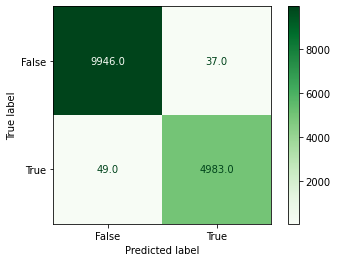

In [13]:
# Kfold implementation, written by Paul Boersma
def kfold_index(df, k=5):
    N = len(df)
    minimum_number_of_points_per_slice = N // k
    remaining_number_of_points = N % k
    starting_point = 0
    out = []
    for islice in range(0, k):
        end_point = starting_point + minimum_number_of_points_per_slice + ( islice < remaining_number_of_points )
        out.append((starting_point, end_point))
        starting_point = end_point
    return out

# Run kfold for given featureset
def execute_kfold(version, feature_type, denoise, k=5):
    acc_train = []
    acc_test = []
    cm = np.zeros((2,2))
    df = build_features(version, feature_type, denoise)
    X, Y = feature_target_split(df)
    for start, end in kfold_index(df, k):
        X_train = np.concatenate((X[:start], X[end:]))
        Y_train = np.concatenate((Y[:start], Y[end:]))
        X_test = X[start:end]
        Y_test = Y[start:end]
        
        model = train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise)
        acc_train.append(model.evaluate(X_train, Y_train, verbose=0)[1])
        acc_test.append(model.evaluate(X_test, Y_test, verbose=0)[1])
        cm += confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
        
    print('Accuracy on train data:', acc_train, np.mean(acc_train))
    print('Accuracy on test data:', acc_test, np.mean(acc_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(cmap="Greens", values_format='')

execute_kfold(1, 'fft', False)

# Live detection

In [14]:
# constants
FORMAT = pyaudio.paFloat32      # audio format (bytes per sample?)
CHANNELS = 1                    # single channel for microphone
SR = 48000                      # samples per second
CHUNK = int((SR / 1000) * STEP) # chunk size
WAVE_OUTPUT_FILENAME = "file.wav"

In [15]:
def live_detect(feature_type, version, denoise, record_seconds=15, write=False):
    # load model
    try:
        model = load_model("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")
    except:
        _, _, model = train_model(version, feature_type, denoise)
    
    # pyaudio class instance
    p = pyaudio.PyAudio()
    buffer = [False] * 10

    # stream object to get data from microphone
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=SR,
        input=True,
        output=True,
        frames_per_buffer=CHUNK
    )

    print("recording...")
    frames = []

    for i in range(0, int(SR / CHUNK * record_seconds)):
        # read chunk
        data = stream.read(CHUNK)
        frames.append(data)
        
        # fetch features
        sample = np.frombuffer(data, dtype=np.float32)
        if feature_type == "fft":
            features = np.mean(np.abs(librosa.stft(sample, n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            features = np.mean(librosa.feature.mfcc(y=sample, sr=SR, n_mfcc=40).T, axis=0)
        
        # make prediction
        features = np.expand_dims(features, axis=0)
        is_whistle = model.predict(features, verbose=0)[0][0]
        
        # print current certainty
        buffer.pop(0)
        buffer.append(is_whistle > .5)
        clear_output(wait=True)
        print("whistle likelihood:", str((sum(buffer)/len(buffer)) * 100) + "%")
        
        
    print("finished recording")

    # stop recording
    stream.stop_stream()
    stream.close()
    p.terminate()

    # write to file
    if write:       
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(p.get_sample_size(FORMAT))
        waveFile.setframerate(SR)
        waveFile.writeframes(b''.join(frames))
        waveFile.close()
        
live_detect("fft", 1, True, write=False)

whistle likelihood: 100.0%
finished recording
